<center><b>EE 538 Autumn 2020<br>
Analog Circuits for Sensor Systems<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Design Project Phase 2: Strain Gage Low-Noise Signal Conditioning<br>
Due Saturday, December 19 (Submit on Canvas as a Jupyter Notebook)</b> 

The final project for this course involves the design of the signal conditioning electronics for a strain gage sensor. You will design amplifier and filter circuits for a strain gage signal produced using a Wheatstone bridge. The goals of this project are:

 - To understand how to translate application specifications (e.g. dynamic range of a sensor output) into circuit specifications
 - To understand the impact of different noise sources in a circuit and how they affect the achievement of performance targets (e.g. SNR)
 - To understand how to choose components and apply gain and filtering to optimize for SNR, power dissipation, and cost
 - To understand the impact of manufacturing variations on performance goals, and how to select components that achieve the optimal balance between performance, component availability, and cost

The project will consist of two phases, each phase lasting 2-3 weeks. At the end of Phase 1 you are asked to submit a Jupyter Notebook providing details of your design choices and the results of any relevant analyses (e.g. circuit analysis, Python scripts, or simulation results). 


| Item               | Due date | Proportion of project grade |
| :---------------- | :------ | :-------------------------: |
| Phase 1 submission | December 6 | 60 % |
| Phase 2 submission | December 19 | 40 % |

__System Architecture__

The noise performance of a sensor system is typically determined by the noise density of the front-end electronics (opamps and resistors) and the bandwidth of the signal path. Sensors may also contribute noise, as is the case for a Wheatstone bridge used the convert the change in resistance of a strain gage to a differential voltage. 

<center><img src="img/system_architecture.png" width=800></center>
<br>
<center><b> Figure 1. Strain gage signal condition architecture.</center>

__Fig 1.__ show the sensor signal conditioning “front-end” architecture for a strain gage sensor. The differential output voltage of the strain gage is amplified by the instrumentation amplifier and converted to a single-ended voltage. The output of the amplifier is fed to a lowpass filter which sets the noise bandwidth of the front-end circuitry. 

The strain gage produces a differential output in response to an applied strain. This occurs as the result of the lengthening or shortening of a conductive element, which in turn changes its resistance. These changes in resistance are typically quite small, as the change in length $\Delta L$ relative to the nominal length $L$ is small, on the order of 0.1% (for example).

Strain gage sensors are typically based on the Wheatstone bridge, a network of four resistances with an “excitation voltage” applied across the bridge ($V_{DD}$ in __Fig. 1__). The number of bridge resistances subjected to strain determines the strain gage sensitivity (expressed in mV/V).


__Phase 2__

The goal of the second phase of the design project is to design a lowpass filter to minimize noise and select an appropriate ADC based on the target signal range and noise properties of your circuit. The ADC should be selected to accomodate the peak-to-peak signal range coming from the filter and should not degrade the noise performance of the system.


| Parameter                            | Specification   | Unit |
| :----------------                    | :------:        | :-------------------------: |
| Supply voltage ($V_{DD}$)            | $5$               | $V$ |
| Peak-to-peak signal amplitude ($V_{out}$)        | $2$               | $V$ |
| Signal-to-noise ratio (after ADC)                | $\geq 75$         | $dB$ | 
| Maximum attenuation at $10kHz$       | 0.5              | $dB$ |  
| Power dissipation ($I_{DD} \cdot V_{DD}$) | Optimize   | $mW$ |
| Cost-per-unit (10,000 units)          | Optimize       |$\$$ |

__Recommended design approach__

 - Determine the input-referred voltage noise rms noise required to meet the SNR specification. This will inform your equivalent noise bandwidth.
 - Determine the filter type and cutoff frequency that meets the attenuation and SNR specs
 - Determine appropriate ADC sample frequency and resolution (the latter will affect noise performance)
 - Use Digikey’s or Analog Devices’ component selection tables to select filter components and the ADC. Make sure that the conversion range of the ADC is enough to convert the $2V$ signal, and that the ADC chip is compatible with a $5V$ supply voltage
 - References voltages (e.g. for active filters) should be generated using a voltage buffer (don't use an ideal voltage source) 

*Note on supply voltage and input range:* You need to ensure that both the single-ended supply voltage of $5V$ and the nominal sensor output voltage ($5V/2 = 2.5V$) are compatible with your opamp selection(s).

__Simulating Noise Performance__

To test the noise performance of your system, including the effect of ADC quantization noise, you will first need to generate a random noise voltage in Python to modeling your input-referred noise. This can be used to drive the input of your circuit with a PWL voltage source in SPICE.

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import csv

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'

def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_xlogy(x, y, xlabel, ylabel, ymin, ymax):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogy(x, y, 'b');
    ax.grid();
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    ax.set_ylim(ymin,ymax)

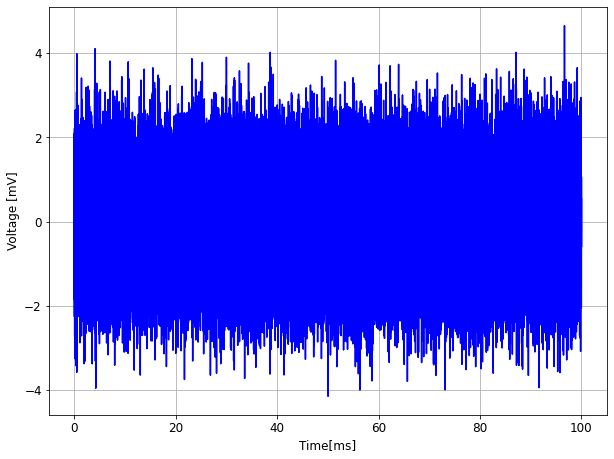

In [2]:
# Your input-referred rms noise before filtering
vn_rms = 1e-3

# Your circuit noise bandwidth will be wider without the filter
fenb = 500e3

# Number of noise samples
N = 100e-3*fenb*2
t = np.arange(N) / fenb / 2

# Generate a random sequence with a Gaussian distribution
vn_in = np.random.normal(0, vn_rms, size=t.shape)

plot_xy(1e3*t, 1e3*vn_in, 'Time[ms]', 'Voltage [mV]')

The noise can be assessed in the frequency domain using power spectral density:

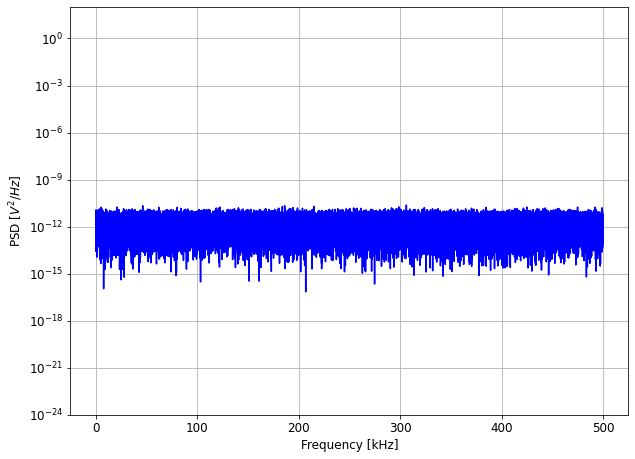

In [3]:
f, en_in_psd = signal.periodogram(vn_in, fenb*2)
plot_xlogy(1e-3*f[1:-2], en_in_psd[1:-2], 'Frequency [kHz]', r'PSD [$V^2/Hz$]', 1e-24, 1e2)

The integrated noise should total the specified $rms$ noise.

In [4]:
vn_rms_calc = np.sqrt(np.sum(en_in_psd)*10)
print('The rms noise calculated from the PSD is', 1e3*vn_rms_calc, 'mV')
print('The rms noise calculated from the time domain is', 1e3*np.std(vn_in), 'mV')

The rms noise calculated from the PSD is 0.9991462799186763 mV
The rms noise calculated from the time domain is 0.9991462799186763 mV


The generated noise sequence should be exported to use with an PWL source in SPICE:

In [5]:
with open('input_noise.csv', 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(t,vn_in))

From the transient simulation, the output of the filter in response to both signal and noise can be imported back into Python for "analog-to-digital conversion". These are imported as separate waveforms to enable comparison of the "raw" signal waveform with that including thermal and quantization noise. 

See the included LTspice file schematic for instructions on how to export the simulated data at a fixed sample rate. The example uses an RC lowpass filter with a $100Hz$ cutoff frequency and a sampling frequency of 20kHz. 

Below I have implemented a simple quantizer using the numpy module *round*. Note that *N_bits* should correspond to the resolution of the ADC you choose.

The resulting waveform *v_quantized* includes the effects of both thermal (analog) noise and quantization noise.

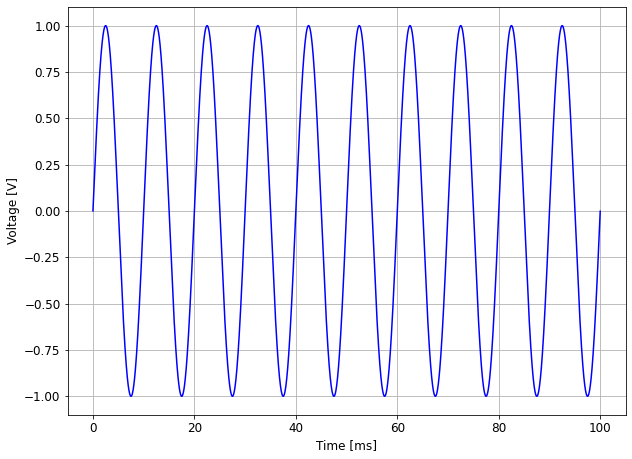

In [6]:
samplerate, data = wavfile.read('sampled_noise.wav')
time = np.arange(0,100e-3,1/samplerate)
if np.size(time) > np.size(data,0):
    time = time[0:np.size(data,0)]

# measured signal and noise votlages
vn_meas = data[0:np.size(time),0]*2/2**32
vsig_meas = data[0:np.size(time),1]/2**31
v_meas = vn_meas + vsig_meas

# ADC qunatization
vref_adc = 1    
N_bits = 24
lsb = vref_adc/2**N_bits
v_quantized = np.round(v_meas/lsb)*lsb

plot_xy(1e3*time, vsig_meas, 'Time [ms]', 'Voltage [V]')

The total noise is the difference between *vsig_meas* and *v_quantized*. In terms of the individual noise sources, *vn_tot* is the *rms sum* of thermal and quantization noise. You should experiment with different values of *N_bits* to understand the effect of ADC resolution on measurement error.

5.014130223141565e-06

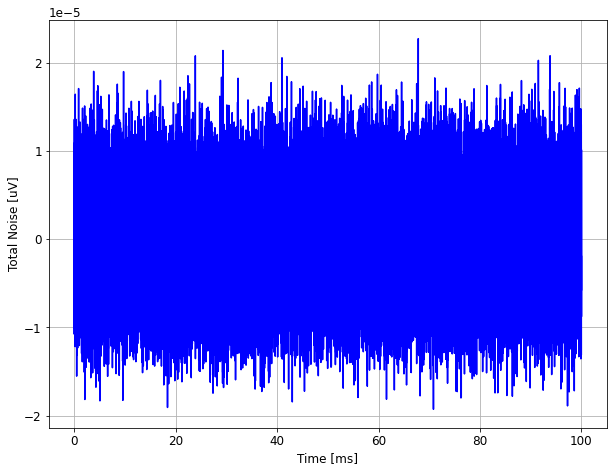

In [7]:
vn_tot = v_quantized - vsig_meas
plot_xy(1e3*time, vn_tot, 'Time [ms]', 'Total Noise [uV]')
np.std(vn_meas)

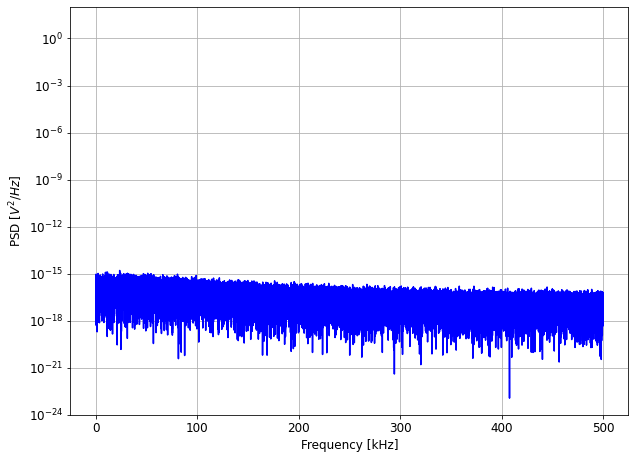

In [8]:
f, en_psd = signal.periodogram(vn_tot, samplerate)
plot_xlogy(1e-3*f[1:-2], en_psd[1:-2], 'Frequency [kHz]', r'PSD [$V^2/Hz$]', 1e-24, 1e2)

The $rms$ noise values calcualted from the time- and frequency-domain data should agree.

In [9]:
vn_rms_psd = np.sqrt(np.sum(en_psd)*10)
vn_rms_td = np.std(vn_tot)

print('The rms noise calculated from the PSD is', 1e6*vn_rms_psd, 'uV')
print('The rms noise calculated from the time domain is', 1e6*vn_rms_td, 'uV')

The rms noise calculated from the PSD is 5.014103726496928 uV
The rms noise calculated from the time domain is 5.01410372649693 uV


The SNR can be calculated as follows:

In [10]:
vsig_rms = np.std(vsig_meas)
print('The measured SNR is ', 20*np.log10(vsig_rms/vn_rms_td), 'dB')

The measured SNR is  102.98582942230162 dB


__Phase 2 deliverables__

Jupyter Notebook summarizing your design. Your submission should be organized into the following sections (with deliverables listed for each). Some of these will carry over from __Phase 1__.

*Instrumentation Amplifier*

1.  A schematic of the amplifier with component values and DC node voltages clearly labeled.
2. A summary of the major noise contributors and the calculated input-referred noise density.
3. Noise simulation result showing the output noise from 0.01Hz to 100MHz and total $rms$ noise *without filtering* (this is the $rms$ noise value that should be used in the time-domain noise simulations described above).
4. A table of components listing the cost for each item assuming a purchase quantity of 10,000. Include a link to a Digikey (or equivalent) listing for each component.

*Lowpass Filter*

1. Filter design based on the target specifications. The ideal (analytical) filter should be modeled in Python to demonstrate that it meets the requirements. You need to calculate the noise bandwidth of your filter and use this to estimate the input-referred  $rms$  noise based on the input-referred noise density of your circuit.
1. Filter schematic with component values and DC node voltages clearly labeled
2. A description of the filter design, including the design parameters for each 2nd order stage (assuming you use a cascaded design)
3. AC simulation results (from 0.1Hz to 100MHz) showing the frequency response of the filter and attenuation at 10kHz. Use the 'Power Bandwidth' in LTspice to measure the filter's noise bandwidth.4. Table of components, as in Part 1

*Top-level Design*

1. Complete schematic showing the strain gage model, instrumentation amplifier, filter, supply voltages, opamp models, resistor values, and DC operating point voltages at all nodes. Indicate the power dissipated by each amplifier by annotating the current through the positive supply pin.
2. Table showing components used, quantity, and cost per unit (assuming a total of 10,000 units)
3. Table listing the power dissipation for each amplifier and a summary of the total power. 
4.  AC simulation results showing the frequency response of the entire circuit (0.1Hz to 100MHz), indicating the attenuation at 10kHz
5.	Input-referred noise plot showing the input-referred noise density at 10kHz, as well as the total integrated noise from 0.1Hz to 100MHz.
6. Time-domain simulation results as described above. Calculate the SNR as shown above using the "measured" (i.e. simulated) signal and noise waveforms (this should include the effects of sampling and ADC quantization noise). Include plots of both the time-domain noise and its power spectral density. 
7. A discussion of major design tradeoffs, any insight you gained throughout the design process, and possible suggestions for improving the architecture

__Notes on the final submission__

 - Sections should be clearly labeled and should be logical and easy to follow.
 -  All plots should be labeled and clearly legible using appropriate colors and scale. Ltspice outputs are acceptable as long as they meet these requirements.
 -  Organize your schematics neatly so that the circuit architecture and all relevant information is clear to the reader.
 
__Grading metrics__

 - Organization/clarity (20%)
 - Completeness (all deliverables included) (60%)
 - Performance/cost (competitively graded) (20%)